In [1]:
# Requirements tensorflow==2.1.0, tensorflow-estimator==2.1.0, tqdm, astropy, pytables, pandas, tensorflow-probability==2.1.0, scikit-learn, matplotlib, seaborn

In [2]:
%cd ".."
!ls

/home/pathdll/git/gerumo
dataset  enviroment.yml  LICENSE    Pipfile    setup.py  train
docs	 gerumo		 notebooks  README.md  tests


In [3]:
from gerumo.data.io import _events_table, _event_attributes
from gerumo.data.io import _array_info_table, _array_attributes

In [4]:
hdf5_filepath = "/home/pathdll/projects/umonna/gamma_20deg_0deg_srun12001-24203___cta-prod3_desert-2150m-Paranal-HB9_cone10.h5"
version = "ML1"

#hdf5_filepath = "D:/sebas/Datasets/gerumo/gamma_20deg_0deg_runs3-1572___cta-prod3-demo_desert-2150m-Paranal-baseline_cone10.h5"
#version = "ML2"

In [5]:
import tables

hdf5_file = tables.open_file(hdf5_filepath, "r")

In [6]:
from os import path

source = path.basename(hdf5_filepath)
folder = path.dirname(hdf5_filepath)

In [7]:
import uuid

In [8]:
import numpy as np

In [9]:
from gerumo.data.io import _telescope_table, _telescopes_info_attributes
from gerumo.data.io import _images_attributes

In [10]:
TELESCOPES_ALIAS = {
    "ML1": {
        "LST_LSTCam":    "LST", 
        "MST_FlashCam":  "MSTF", 
        "SST1M_DigiCam": "SST1"
    },
    "ML2": {
        "LST_LSTCam":    "LST_LSTCam", 
        "MST_FlashCam":  "MST_FlashCam",
        "SST1M_DigiCam": "SST1M_DigiCam"
    } 
}

In [11]:
TELESCOPES = ["LST_LSTCam", "MST_FlashCam", "SST1M_DigiCam"]

In [54]:
# Array data
array_data = {}
# Telescopes Ids
real_telescopes_id = {}
for telescope in hdf5_file.root[_array_info_table[version]]:
    telescope_type = telescope[_array_attributes[version]["type"]]
    telescope_type = telescope_type.decode("utf-8") if isinstance(telescope_type, bytes) else telescope_type
    telescope_id = telescope[_array_attributes[version]["telescope_id"]]
    if telescope_type not in array_data:
        array_data[telescope_type] = {}
        real_telescopes_id[telescope_type] = []

    array_data[telescope_type][telescope_id] = {
        "id": telescope_id,
        "x": telescope[_array_attributes[version]["x"]],
        "y": telescope[_array_attributes[version]["y"]],
        "z": telescope[_array_attributes[version]["z"]],
    }
    if version == "ML1":
        run_array_direction = telescope["run_array_direction"]
    real_telescopes_id[telescope_type].append(telescope_id)

In [55]:
info = hdf5_file.root[_array_info_table[version]]

In [40]:
array_data

{'SSTC': {150: {'id': 150, 'x': 205.5, 'y': 158.89999389648438, 'z': 5.0},
  151: {'id': 151, 'x': 205.5, 'y': -158.89999389648438, 'z': 5.0},
  152: {'id': 152, 'x': -205.5, 'y': 158.89999389648438, 'z': 5.0},
  153: {'id': 153, 'x': -205.5, 'y': -158.89999389648438, 'z': 5.0},
  154: {'id': 154, 'x': 164.82301330566406, 'y': 424.823974609375, 'z': 5.0},
  155: {'id': 155, 'x': 164.82301330566406, 'y': -424.823974609375, 'z': 5.0},
  156: {'id': 156, 'x': -164.82301330566406, 'y': 424.823974609375, 'z': 5.0},
  157: {'id': 157, 'x': -164.82301330566406, 'y': -424.823974609375, 'z': 5.0},
  158: {'id': 158, 'x': 494.468994140625, 'y': 110.0, 'z': 5.0},
  159: {'id': 159, 'x': 494.468994140625, 'y': -110.0, 'z': 5.0},
  160: {'id': 160, 'x': -494.468994140625, 'y': 110.0, 'z': 5.0},
  161: {'id': 161, 'x': -494.468994140625, 'y': -110.0, 'z': 5.0},
  162: {'id': 162, 'x': 0.0, 'y': 519.7949829101562, 'z': 5.0},
  163: {'id': 163, 'x': 0.0, 'y': -519.7949829101562, 'z': 5.0},
  164: {'id

In [13]:
events_data = []
telescopes_data = []

for i, event in enumerate(hdf5_file.root[_events_table[version]]):
    # Event data
    event_unique_id = uuid.uuid4().hex[:20]
    event_data = dict(
                event_unique_id = event_unique_id,
                event_id = event[_event_attributes[version]["event_id"]] ,
                source = source,
                folder = folder,
                core_x = event[_event_attributes[version]["core_x"]],
                core_y = event[_event_attributes[version]["core_y"]],
                h_first_int = event[_event_attributes[version]["h_first_int"]],
                alt = event[_event_attributes[version]["alt"]],
                az = event[_event_attributes[version]["az"]],
                mc_energy = event[_event_attributes[version]["mc_energy"]]
    )
    events_data.append(event_data)
    
    # Observations data
    ## For each telescope type
    for telescope_type in TELESCOPES:
        telescope_type_alias = TELESCOPES_ALIAS[version][telescope_type]
        telescope_indices = f"{telescope_type_alias}_indices"
        telescopes = event[telescope_indices]
        # number of activated telescopes
        if version == "ML2":
            telescope_multiplicity = f"{telescope_type_alias}_multiplicity"
            multiplicity = event[telescope_multiplicity]
        else:
            multiplicity = np.sum(telescopes != 0)
            
        if multiplicity == 0: # No telescope of this type were activated
            continue

        # Select activated telescopes
        activation_mask = telescopes != 0
        activated_telescopes = np.arange(len(telescopes))[activation_mask]
        observation_indices = telescopes[activation_mask]

        ## For each activated telescope
        for activate_telescope, observation_indice in zip(activated_telescopes, observation_indices):
            # Telescope Data
            real_telescope_id = real_telescopes_id[telescope_type_alias][activate_telescope]
            telescope_data = dict(
                telescope_id = real_telescope_id,
                event_unique_id = event_unique_id,
                type = telescope_type,
                x = array_data[telescope_type_alias][real_telescope_id]["x"],
                y = array_data[telescope_type_alias][real_telescope_id]["y"],
                z = array_data[telescope_type_alias][real_telescope_id]["z"],
                observation_indice = observation_indice
            )
            telescopes_data.append(telescope_data)

In [14]:
for tel in telescopes_data:
    alias = TELESCOPES_ALIAS[version][tel["type"]]
    print(tel)
    tel_observations = hdf5_file.root[alias]
    break
tel_observations

{'telescope_id': 6, 'event_unique_id': '35cd6f023b8f467794a4', 'type': 'MST_FlashCam', 'x': 0.0, 'y': 151.1999969482422, 'z': 10.0, 'observation_indice': 1}


/MSTF (Table(1932,)) 'Table of MSTF images'
  description := {
  "event_index": Int32Col(shape=(), dflt=0, pos=0),
  "image_charge": Float32Col(shape=(1764,), dflt=0.0, pos=1),
  "image_peak_times": Float32Col(shape=(1764,), dflt=0.0, pos=2)}
  byteorder := 'little'
  chunkshape := (18,)

In [15]:
telescopes_info = hdf5_file.root[_telescope_table[version]]

In [16]:
raw_pixpos = {}
for telescope in telescopes_info:
    type_ = telescope[_telescopes_info_attributes[version]["type"]].decode("utf-8")
    num_pixels = telescope[_telescopes_info_attributes[version]["num_pixels"]]
    if version == "ML2":
        raw_pixpos[type_] = telescope[_telescopes_info_attributes[version]["pixel_pos"]][:num_pixels, :].T
    else:
        raw_pixpos[type_] = telescope[_telescopes_info_attributes[version]["pixel_pos"]][:, :num_pixels]

In [17]:
observations = dict()


for tel_type in TELESCOPES:
    observations[tel_type] = dict()
    tel_alias = TELESCOPES_ALIAS[version][tel_type]
    tel_table = hdf5_file.root[tel_alias]
        
    for i, tel_data in enumerate(telescopes_data):
        event_id = tel_data["event_unique_id"]
        obs_id = tel_data["observation_indice"]
        print(tel_table)
        try:
            image = tel_table[obs_id]
        except:
            continue
        
        observations[tel_type][obs_id] = dict(
            charge= image[_images_attributes[version]["charge"]],
            peakpos= image[_images_attributes[version]["peakpos"]],
            pix_pos= raw_pixpos[tel_alias]
        )

/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,

/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,

/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,

/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,

/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,)) 'Table of LST images'
/LST (Table(459,

/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of M

/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of M

/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of M

/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of M

/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of M

/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of M

/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of M

/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of M

/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of M

/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of M

/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of M

/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of M

/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of M

/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of M

/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of M

/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of MSTF images'
/MSTF (Table(1932,)) 'Table of M

/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of S

/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of S

/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of S

/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of S

/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of S

/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of S

/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of S

/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of S

/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of S

/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of SST1 images'
/SST1 (Table(1131,)) 'Table of S

In [18]:
print(observations)

{'LST_LSTCam': {1: {'charge': array([ 0.08864418, -0.06092395,  2.3836691 , ..., -1.0637388 ,
        2.5547857 , -0.8987273 ], dtype=float32), 'peakpos': array([24., 11., 10., ...,  4., 28.,  2.], dtype=float32), 'pix_pos': array([[ 0.        , -0.00944877, -0.0472442 , ..., -0.6519913 ,
        -0.6141959 , -0.62364465],
       [ 0.        ,  0.04909909,  0.01636691, ..., -0.9656089 ,
        -0.9328767 , -0.8837776 ]], dtype=float32)}, 2: {'charge': array([ 0.13351822,  0.9869007 ,  4.2134504 , ...,  0.08526104,
       -0.91924703,  0.02316099], dtype=float32), 'peakpos': array([12., 17., 12., ..., 29.,  2., 29.], dtype=float32), 'pix_pos': array([[ 0.        , -0.00944877, -0.0472442 , ..., -0.6519913 ,
        -0.6141959 , -0.62364465],
       [ 0.        ,  0.04909909,  0.01636691, ..., -0.9656089 ,
        -0.9328767 , -0.8837776 ]], dtype=float32)}, 3: {'charge': array([-1.8181574 , -0.09653375, -1.5550406 , ...,  1.7584524 ,
       -2.6840513 ,  0.18251261], dtype=float32), 'p

## Hillas Reconstruction

In [19]:
from gerumo import *

In [20]:
from ctapipe.instrument import CameraDescription
from ctapipe.visualization import CameraDisplay

In [75]:
import astropy.units as u
from astropy.coordinates import SkyCoord, AltAz

from ctapipe.io import event_source
from ctapipe.utils.datasets import get_dataset_path

from ctapipe.calib import CameraCalibrator
from ctapipe.instrument import SubarrayDescription, TelescopeDescription

from ctapipe.image import tailcuts_clean, number_of_islands
from ctapipe.image import hillas_parameters, leakage, concentration
from ctapipe.image import timing_parameters

from ctapipe.reco import HillasReconstructor

from ctapipe.io import HDF5TableWriter

cleaning_level = {
    'ASTRICam': (5, 7, 2),
    'LSTCam': (3.5, 7.5, 2),
    'FlashCam': (4, 8, 2)
}

In [103]:
tel_positions = dict()
tel_descriptions = dict()
for tel in telescopes_data:
    tel_id = tel["telescope_id"]
    tel_name = tel['type'].split('_')
    try:
        tel_descriptions[tel_id] = TelescopeDescription.from_name(optics_name=tel_name[0], camera_name=tel_name[1])
    except:
        continue
    tel_positions[tel_id] = [tel['x'], tel['y'], tel['z']]
subarray = SubarrayDescription("ML1", tel_positions=tel_positions, tel_descriptions=tel_descriptions)

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exis

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (D

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (D

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (Fl

Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (Fl

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (F

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LS

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exis

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exis

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (Flash

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exi

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: 

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (Fl

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LST

Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.c

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiC

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exis

Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist:

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist:

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCa

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (Flas

Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (Fla

Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LS

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist:

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: 

Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist:

Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist:

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist:

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (Fl

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (D

In [107]:
telescopes_data

[{'telescope_id': 6,
  'event_unique_id': '35cd6f023b8f467794a4',
  'type': 'MST_FlashCam',
  'x': 0.0,
  'y': 151.1999969482422,
  'z': 10.0,
  'observation_indice': 1},
 {'telescope_id': 8,
  'event_unique_id': '35cd6f023b8f467794a4',
  'type': 'MST_FlashCam',
  'x': 146.65599060058594,
  'y': 75.5999984741211,
  'z': 10.0,
  'observation_indice': 2},
 {'telescope_id': 12,
  'event_unique_id': '35cd6f023b8f467794a4',
  'type': 'MST_FlashCam',
  'x': 154.2050018310547,
  'y': 238.4739990234375,
  'z': 10.0,
  'observation_indice': 3},
 {'telescope_id': 20,
  'event_unique_id': '35cd6f023b8f467794a4',
  'type': 'MST_FlashCam',
  'x': 315.468017578125,
  'y': 162.62100219726562,
  'z': 10.0,
  'observation_indice': 4},
 {'telescope_id': 220,
  'event_unique_id': '35cd6f023b8f467794a4',
  'type': 'SST1M_DigiCam',
  'x': 205.5,
  'y': 158.89999389648438,
  'z': 5.0,
  'observation_indice': 1},
 {'telescope_id': 16,
  'event_unique_id': '9d71aa4c9825482c93d3',
  'type': 'MST_FlashCam',
  '

In [111]:
for tel in telescopes_data:
    print(tel["event_unique_id"])
    
for event in events_data:
    print(event["event_unique_id"])

35cd6f023b8f467794a4
35cd6f023b8f467794a4
35cd6f023b8f467794a4
35cd6f023b8f467794a4
35cd6f023b8f467794a4
9d71aa4c9825482c93d3
9d71aa4c9825482c93d3
9d71aa4c9825482c93d3
9d71aa4c9825482c93d3
9d71aa4c9825482c93d3
1149fac2eb104332ade3
1149fac2eb104332ade3
1149fac2eb104332ade3
1149fac2eb104332ade3
1149fac2eb104332ade3
465fdf789a654e82aa02
465fdf789a654e82aa02
25a245b0fd784793ab1f
25a245b0fd784793ab1f
9a3333e36d634a73b620
ef2237625dcb42438c7d
ef2237625dcb42438c7d
6c8f0ae38fb946a5981c
1fca2bd5962642bcb1e1
1fca2bd5962642bcb1e1
1a7031dd75784dd2acf7
dd0f3eff3999433aaab7
dd0f3eff3999433aaab7
6d716af22a7449e4b31c
6d716af22a7449e4b31c
6d716af22a7449e4b31c
e8a74ae29eaa4c14bb4e
e8a74ae29eaa4c14bb4e
e8a74ae29eaa4c14bb4e
e8a74ae29eaa4c14bb4e
e8a74ae29eaa4c14bb4e
0d3586accd024f269a80
0d3586accd024f269a80
0d3586accd024f269a80
0d3586accd024f269a80
0d3586accd024f269a80
6b2c0ea85e884f2ea90a
6b2c0ea85e884f2ea90a
6b2c0ea85e884f2ea90a
6b2c0ea85e884f2ea90a
6b2c0ea85e884f2ea90a
6b2c0ea85e884f2ea90a
6b2c0ea85e884

332fdcc6a26a4718a462
332fdcc6a26a4718a462
332fdcc6a26a4718a462
794480bb42f74eedafed
794480bb42f74eedafed
794480bb42f74eedafed
b6d15158e6b04ca08a02
b6d15158e6b04ca08a02
a15e095ae78f48cca8d9
a15e095ae78f48cca8d9
45fa30a6571c49ff98c7
45fa30a6571c49ff98c7
d519cd2b15e04f059dbc
d519cd2b15e04f059dbc
d519cd2b15e04f059dbc
8af83084d40245b1ac80
8af83084d40245b1ac80
8af83084d40245b1ac80
8af83084d40245b1ac80
9c5706daaad54982bfb9
9c5706daaad54982bfb9
d5b9a38c7a78411394a5
d5b9a38c7a78411394a5
d5b9a38c7a78411394a5
6872b2d169ab44d1b647
6872b2d169ab44d1b647
539fa2fcf3dd4c6185c6
f673d5ca60ab47aeb3ec
f673d5ca60ab47aeb3ec
f673d5ca60ab47aeb3ec
b6dde4e47c4145f294b4
b6dde4e47c4145f294b4
7e1552ac5b1f4b85ad1f
7e1552ac5b1f4b85ad1f
e6e4d1a4b0104a35aaad
e6e4d1a4b0104a35aaad
cfa75dbf5bd742ce9930
cfa75dbf5bd742ce9930
b4d83c48924743099f36
fc6dd93984a94676961a
fc6dd93984a94676961a
1e5b26dfe98d4cadbc51
1e5b26dfe98d4cadbc51
1e5b26dfe98d4cadbc51
1e5b26dfe98d4cadbc51
1e5b26dfe98d4cadbc51
1e5b26dfe98d4cadbc51
1e5b26dfe98d4

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)


{'event_unique_id': '35cd6f023b8f467794a4', 'event_id': 2106, 'source': 'gamma_20deg_0deg_srun12001-24203___cta-prod3_desert-2150m-Paranal-HB9_cone10.h5', 'folder': '/home/pathdll/projects/umonna', 'core_x': 374.1986999511719, 'core_y': 73.97764587402344, 'h_first_int': 20917.6328125, 'alt': 1.2885076999664307, 'az': 6.096007347106934, 'mc_energy': 1.0650138854980469}
  Alt: 74.00° | real: 1.29°
  Az: -11.45° | real: 6.10°
  Hmax: 7292 m
  CoreX: 398.6 m
  CoreY: 58.0 m


Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exi

{'event_unique_id': '6d716af22a7449e4b31c', 'event_id': 115307, 'source': 'gamma_20deg_0deg_srun12001-24203___cta-prod3_desert-2150m-Paranal-HB9_cone10.h5', 'folder': '/home/pathdll/projects/umonna', 'core_x': -92.1231918334961, 'core_y': -280.1468200683594, 'h_first_int': 48771.375, 'alt': 1.2277294397354126, 'az': 6.168917655944824, 'mc_energy': 0.043668732047080994}
  Alt: 70.33° | real: 1.23°
  Az: -6.42° | real: 6.17°
  Hmax: 16016 m
  CoreX: -98.3 m
  CoreY: -186.5 m


Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (Fla

{'event_unique_id': '6b2c0ea85e884f2ea90a', 'event_id': 126811, 'source': 'gamma_20deg_0deg_srun12001-24203___cta-prod3_desert-2150m-Paranal-HB9_cone10.h5', 'folder': '/home/pathdll/projects/umonna', 'core_x': -368.76715087890625, 'core_y': -98.59768676757812, 'h_first_int': 22670.943359375, 'alt': 1.1663604974746704, 'az': 6.161973476409912, 'mc_energy': 3.516292095184326}
  Alt: 66.96° | real: 1.17°
  Az: -6.83° | real: 6.16°
  Hmax: 7960 m
  CoreX: -321.2 m
  CoreY: -58.3 m


Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (D

{'event_unique_id': 'eab45765eede483db905', 'event_id': 126815, 'source': 'gamma_20deg_0deg_srun12001-24203___cta-prod3_desert-2150m-Paranal-HB9_cone10.h5', 'folder': '/home/pathdll/projects/umonna', 'core_x': -446.04840087890625, 'core_y': -460.7856750488281, 'h_first_int': 22670.943359375, 'alt': 1.1663604974746704, 'az': 6.161973476409912, 'mc_energy': 3.516292095184326}
  Alt: 67.47° | real: 1.17°
  Az: -4.93° | real: 6.16°
  Hmax: 8759 m
  CoreX: -247.3 m
  CoreY: -258.4 m


Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist:

{'event_unique_id': '12198535d554491e968c', 'event_id': 126819, 'source': 'gamma_20deg_0deg_srun12001-24203___cta-prod3_desert-2150m-Paranal-HB9_cone10.h5', 'folder': '/home/pathdll/projects/umonna', 'core_x': -405.5697021484375, 'core_y': -97.39623260498047, 'h_first_int': 22670.943359375, 'alt': 1.1663604974746704, 'az': 6.161973476409912, 'mc_energy': 3.516292095184326}
  Alt: 66.83° | real: 1.17°
  Az: -6.94° | real: 6.16°
  Hmax: 7992 m
  CoreX: -288.5 m
  CoreY: 12.2 m


Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)


KeyboardInterrupt: 

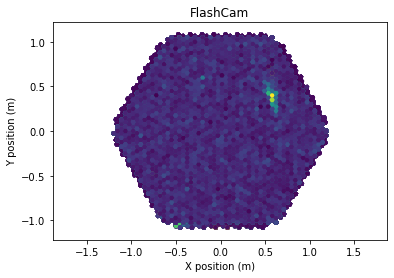

In [118]:
horizon_frame = AltAz()
reco = HillasReconstructor()

for event in events_data:
    hillas_containers = {}
    telescope_pointings = {}
    time_gradients = {}

    for tel in telescopes_data:
        if tel["event_unique_id"] != event["event_unique_id"]:
            continue
        telescope_id = tel["telescope_id"]
        obs_id = tel["observation_indice"]
        tel_type = tel["type"]
        cam_name = tel_type.split("_")[1]

        geometry = CameraDescription.from_name(cam_name).geometry

        if geometry.camera_name not in cleaning_level:
            continue
        boundary, picture, min_neighbors = cleaning_level[geometry.camera_name]

        image = observations[tel_type][obs_id]["charge"]
        peak_time = observations[tel_type][obs_id]["peakpos"]

        clean = tailcuts_clean(
            geometry,
            image,
            boundary_thresh=boundary,
            picture_thresh=picture,
            min_number_picture_neighbors=min_neighbors
        )
        
        if clean.sum() < 5:
            continue
            
        disp = CameraDisplay(geometry, image=image)
        hillas_c = hillas_parameters(geometry[clean], image[clean])
        leakage_c = leakage(geometry, image, clean)
        n_islands, island_ids = number_of_islands(geometry, clean)

        if leakage_c.intensity_width_2 > 0.2:
            continue

        timing_c = timing_parameters(geometry, image, peak_time, hillas_c, clean)

        hillas_containers[telescope_id] = hillas_c

        # ssts have no timing in prod3b, so we'll use the skewness
        time_gradients[telescope_id] = timing_c.slope.value if geometry.camera_name != 'ASTRICam' else hillas_c.skewness

        # this makes sure, that we get an arrow in the array plow for each telescope
        # might have the wrong direction though
        if abs(time_gradients[telescope_id]) < 0.2:
            time_gradients[telescope_id] = 1.0

    array_pointing = SkyCoord(
        az=run_array_direction[0] * u.rad,
        alt=run_array_direction[1] * u.rad,
        frame=horizon_frame
    )

    if len(hillas_containers) > 1:
        stereo = reco.predict(hillas_containers, subarray, array_pointing)

        print(event)
        print('  Alt: {:.2f}° | real: {:.2f}°'.format(stereo.alt.deg, event['alt']))
        print('  Az: {:.2f}° | real: {:.2f}°'.format(stereo.az.deg, event['az']))
        print('  Hmax: {:.0f}'.format(stereo.h_max))
        print('  CoreX: {:.1f}'.format(stereo.core_x))
        print('  CoreY: {:.1f}'.format(stereo.core_y))


In [ ]:
hdf5_file.close()